In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

Unique labels in y_label: [1 2 3 4 5 6 7]
Number of unique labels: 7


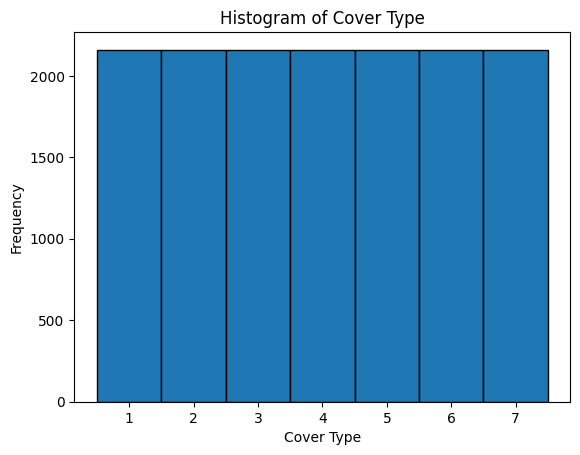

In [11]:
# Load the dataset
data = pd.read_csv("forest-3-a-2024/train.csv")

# Separate features and the target
train = data.drop(columns=["Id", "Cover_Type"])
y = data["Cover_Type"]

# Data preprocessing
# add new features from feature engineering
train['Elev_to_Horizontal_Hyd'] = train.Elevation - 0.2 * train.Horizontal_Distance_To_Hydrology 
train['Elev_to_Horizontal_Road'] = train.Elevation - 0.05 * train.Horizontal_Distance_To_Roadways  
train['Elev_to_Verticle_Hyd'] = train.Elevation - train.Vertical_Distance_To_Hydrology 
train['Mean_Horizontal_Dist'] = (train.Horizontal_Distance_To_Fire_Points + train.Horizontal_Distance_To_Hydrology + 
                                 train.Horizontal_Distance_To_Roadways)/3 
train['Mean_Fire_Hydro'] = (train.Horizontal_Distance_To_Fire_Points + train.Horizontal_Distance_To_Hydrology)/2

# Check the number of unique labels in y
unique_labels = y.unique()
num_unique_labels = y.nunique()

print("Unique labels in y_label:", unique_labels)
print("Number of unique labels:", num_unique_labels)

# Convert the data to a numpy array
X = train.values
y = y.values

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert the data from Numpy arrays to Tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train = torch.from_numpy(X_train).float().to(device)
X_test = torch.from_numpy(X_test).float().to(device)
y_train = torch.from_numpy(y_train).long().to(device)
y_test = torch.from_numpy(y_test).long().to(device)

# Create data loaders
batch_size = 64
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)


# Plot histogram of y_labels
plt.hist(y, bins=np.arange(y.min(), y.max()+2) - 0.5, edgecolor='black')
plt.xlabel('Cover Type')
plt.ylabel('Frequency')
plt.title('Histogram of Cover Type')
plt.xticks(np.arange(y.min(), y.max()+1))
plt.show()

In [12]:
class NN(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_hidden)
        self.fc3 = nn.Linear(n_hidden, n_hidden)
        self.fc4 = nn.Linear(n_hidden, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return F.log_softmax(x, dim=1)

In [13]:

def train(model, device, train_loader, optimizer, epoch):
    log_interval=100
    model.train() #set model in train mode
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        
        #TODO: introduce the loss here
        loss = F.nll_loss(output, target)
        
        
        
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval() #set model in test mode
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [14]:
input_size = X_train.shape[1]
n_hidden = input_size*3
output_size = 8
# print("input_size: ", input_size)
# print("n_hidden: ", n_hidden)

model = NN(input_size, n_hidden, output_size)
model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

for epoch in range(1, 20):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)


Train Epoch: 1 [0/12096 (0%)]	Loss: 46.745449
Train Epoch: 1 [6400/12096 (53%)]	Loss: 1.854531

Test set: Average loss: 1.6380, Accuracy: 1010/3024 (33%)

Train Epoch: 2 [0/12096 (0%)]	Loss: 1.685816
Train Epoch: 2 [6400/12096 (53%)]	Loss: 1.796291

Test set: Average loss: 1.5973, Accuracy: 1184/3024 (39%)

Train Epoch: 3 [0/12096 (0%)]	Loss: 1.520651
Train Epoch: 3 [6400/12096 (53%)]	Loss: 1.655024

Test set: Average loss: 1.6054, Accuracy: 1092/3024 (36%)

Train Epoch: 4 [0/12096 (0%)]	Loss: 1.659329
Train Epoch: 4 [6400/12096 (53%)]	Loss: 1.612212

Test set: Average loss: 1.4800, Accuracy: 1321/3024 (44%)

Train Epoch: 5 [0/12096 (0%)]	Loss: 1.337501
Train Epoch: 5 [6400/12096 (53%)]	Loss: 1.482215

Test set: Average loss: 1.4707, Accuracy: 1221/3024 (40%)

Train Epoch: 6 [0/12096 (0%)]	Loss: 1.297027
Train Epoch: 6 [6400/12096 (53%)]	Loss: 1.432056

Test set: Average loss: 1.4358, Accuracy: 1305/3024 (43%)

Train Epoch: 7 [0/12096 (0%)]	Loss: 1.387481
Train Epoch: 7 [6400/12096 (53